<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%A0%9C%EC%A3%BC%EB%8F%84_%EB%8F%84%EB%A1%9C_%EA%B5%90%ED%86%B5%EB%9F%89_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

제주도 도로 교통량 예측 AI 경진대회 https://dacon.io/competitions/official/235985/overview/description

#module

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors  import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

In [5]:
pd.set_option('display.max_columns', 500)

#data load

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/test.csv')
data_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/data_info.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/sample_submission.csv')

# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   road_in_use            int64  
 5   lane_count             int64  
 6   road_rating            int64  
 7   road_name              object 
 8   multi_linked           int64  
 9   connect_code           int64  
 10  maximum_speed_limit    float64
 11  vehicle_restricted     float64
 12  weight_restricted      float64
 13  height_restricted      float64
 14  road_type              int64  
 15  start_node_name        object 
 16  start_latitude         float64
 17  start_longitude        float64
 18  start_turn_restricted  object 
 19  end_node_name          object 
 20  end_latitude           float64
 21  end_longitude          float64
 22  end_turn_restricte

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [6]:
test.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,0,3,107,연삼로,0,0,70.0,0.0,0.0,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,0,2,103,일반국도12호선,0,0,70.0,0.0,0.0,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,0,1,103,일반국도16호선,0,0,60.0,0.0,0.0,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,0,3,103,일반국도11호선,0,0,70.0,0.0,0.0,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,0,3,106,번영로,0,0,70.0,0.0,0.0,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [ ]:
train.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [ ]:
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


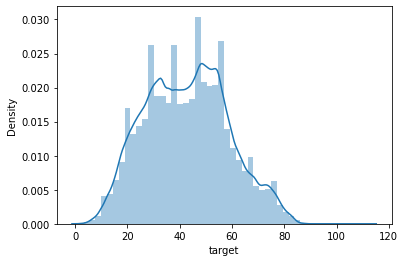

In [ ]:
sns.distplot(train['target'])
plt.show()

## 날짜 데이터(base_date, day_of_week, base_hour	)

In [ ]:
date_year = pd.to_datetime(train['base_date'], format='%Y%m%d').dt.year
date_year

0          2022
1          2022
2          2021
3          2022
4          2021
           ... 
4701212    2021
4701213    2022
4701214    2022
4701215    2021
4701216    2021
Name: base_date, Length: 4701217, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


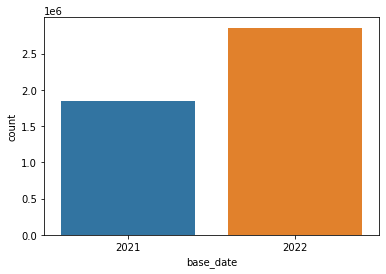

In [ ]:
sns.countplot(date_year)
plt.show()

In [ ]:
train['date_year'] = date_year

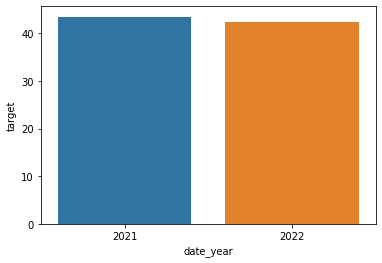

In [ ]:
sns.barplot(x='date_year', y='target', data=train)
plt.show()

연도 불필요

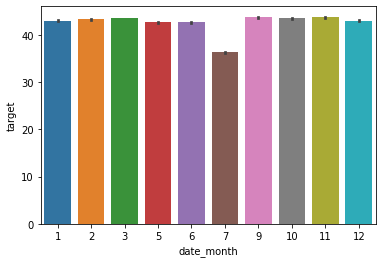

In [ ]:
train['date_month'] = pd.to_datetime(train['base_date'], format='%Y%m%d').dt.month
sns.barplot(x='date_month', y='target', data=train)
plt.show()

7월만 저하 7월을 다른 값으로?

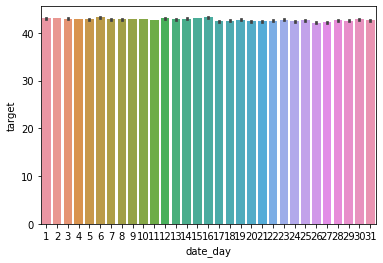

In [ ]:
train['date_day'] = pd.to_datetime(train['base_date'], format='%Y%m%d').dt.day
sns.barplot(x='date_day', y='target', data=train)
plt.show()

날짜별 의미없음 제거

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

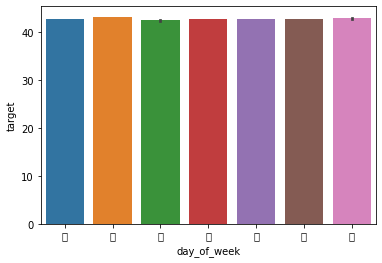

In [ ]:
sns.barplot(x='day_of_week', y='target', data=train)
plt.show()

요일별 차이 없음

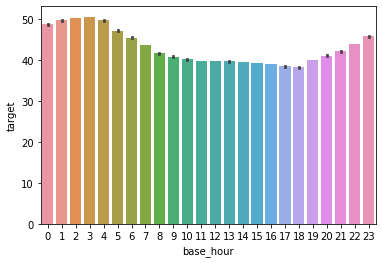

In [ ]:
sns.barplot(x='base_hour', y='target', data=train)
plt.show()

시간대별 분류 4등분?

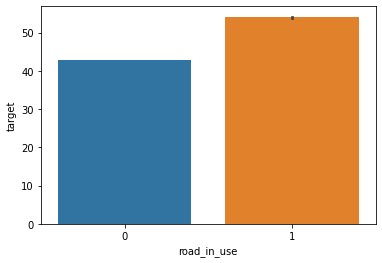

In [ ]:
sns.barplot(x='road_in_use', y='target', data=train)
plt.show()

road_in_use 사용

In [ ]:
train['lane_count'].value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

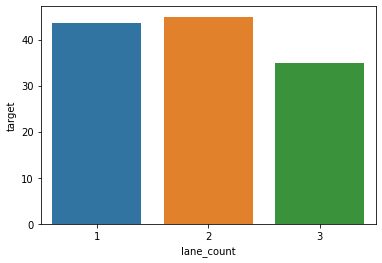

In [ ]:
sns.barplot(x='lane_count', y='target', data=train)
plt.show()

유의미함 순서변경? 아니면 원핫인코딩

In [ ]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

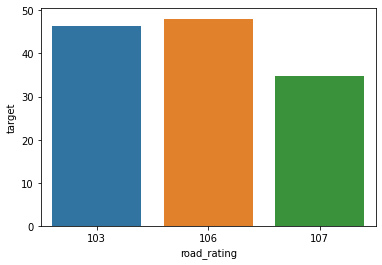

In [ ]:
sns.barplot(x='road_rating', y='target', data=train)
plt.show()

유의미함 순서변경? 아니면 원핫인코딩

In [ ]:
train['multi_linked'].value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

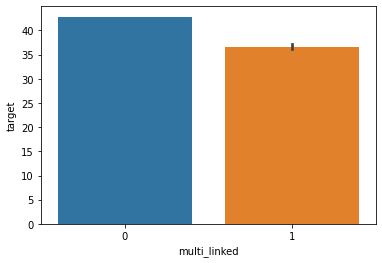

In [ ]:
sns.barplot(x='multi_linked', y='target', data=train)
plt.show()

유의미함

In [ ]:
train['connect_code'].value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

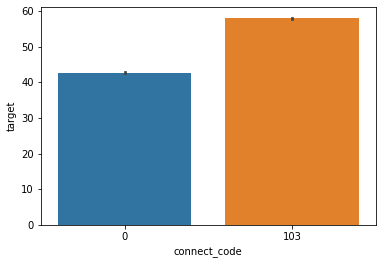

In [ ]:
sns.barplot(x='connect_code', y='target', data=train)
plt.show()

유의미함 0, 1로 변환

In [ ]:
train['maximum_speed_limit'].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

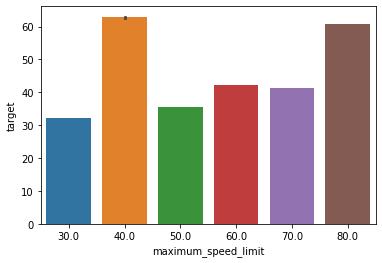

In [ ]:
ㅊ

40에서 가장높음? 가장 숫자도 적고 확인 필요

In [ ]:
train['weight_restricted'].value_counts()

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

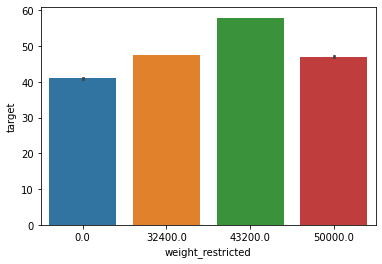

In [ ]:
sns.barplot(x='weight_restricted', y='target', data=train)
plt.show()

증가하다 50000에서 감소

In [ ]:
train['height_restricted'].value_counts()

0.0    4701217
Name: height_restricted, dtype: int64

0만 가짐 제거

In [ ]:
train['road_type'].value_counts()

0    3737117
3     964100
Name: road_type, dtype: int64

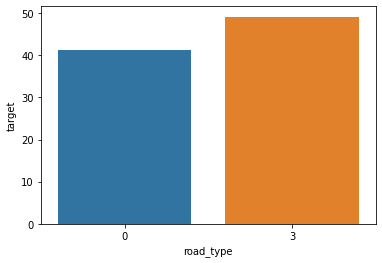

In [ ]:
sns.barplot(x='road_type', y='target', data=train)
plt.show()

유의미함 0, 1로 변경

In [ ]:
train['start_latitude'].unique()

In [ ]:
train['start_latitude'].min(), train['start_latitude'].max()

(33.2434317486804, 33.5560801767072)

In [ ]:
train['start_latitude_r'] = train['start_latitude'].apply(lambda x : round(x, 2))

In [ ]:
train['start_latitude_r'].value_counts()

33.25    686227
33.26    477299
33.49    329845
33.50    270183
33.48    243039
33.47    218447
33.44    199857
33.45    198830
33.42    184689
33.41    170815
33.51    154412
33.52    140860
33.28    138038
33.46    133287
33.29    124450
33.35     98774
33.32     95832
33.43     94867
33.27     87269
33.39     86943
33.31     62385
33.34     56844
33.55     55692
33.36     51216
33.37     49669
33.30     44448
33.40     44303
33.24     43591
33.33     41257
33.38     41081
33.53     36547
33.54     31649
33.56      8572
Name: start_latitude_r, dtype: int64

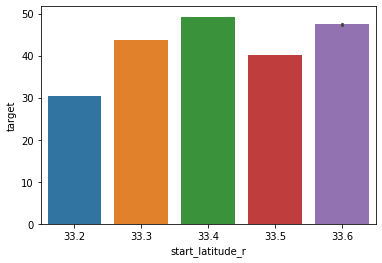

In [ ]:
sns.barplot(x='start_latitude_r', y='target', data=train)
plt.show()

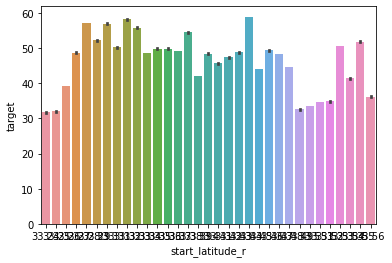

In [ ]:
sns.barplot(x='start_latitude_r', y='target', data=train)
plt.show()

0.1 단위로 5등분

In [ ]:
train['start_longitude'].unique()

In [ ]:
train['start_longitude_r'] = train['start_longitude'].apply(lambda x : round(x, 2))

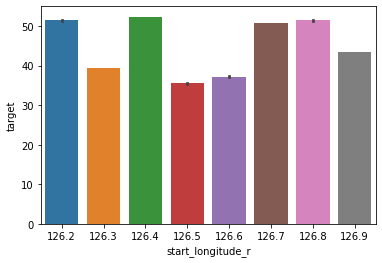

In [ ]:
sns.barplot(x='start_longitude_r', y='target', data=train)
plt.show()

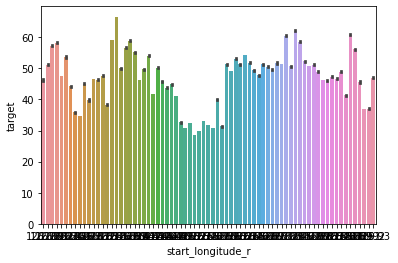

In [ ]:
sns.barplot(x='start_longitude_r', y='target', data=train)
plt.show()

8개로 나뉨 합쳐서 출발점 생성

In [ ]:
 train['start'] = train['start_latitude_r'].map(str) + ', '+ train['start_longitude_r'].map(str)

In [ ]:
 train['start'].nunique()

269

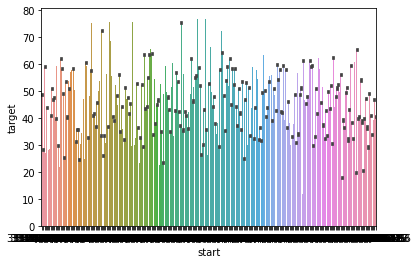

In [ ]:
sns.barplot(x='start', y='target', data=train)
plt.show()

In [ ]:
train['start_turn_restricted'].value_counts()

없음    4239701
있음     461516
Name: start_turn_restricted, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51080 missing from current font.
  font.set_text

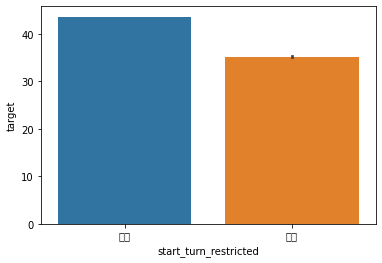

In [ ]:
sns.barplot(x='start_turn_restricted', y='target', data=train)
plt.show()

In [ ]:
train['end_latitude_r'] = train['end_latitude'].apply(lambda x : round(x, 2))

In [ ]:
train['end_longitude_r'] = train['end_longitude'].apply(lambda x : round(x, 2))

In [ ]:
train['distance'] = ((train['end_longitude_r'] - train['start_longitude_r']) ** 2 + (train['end_latitude_r'] - train['start_latitude_r']) ** 2) **0.5

In [ ]:
train['distance'].value_counts()

0.000000    2927529
0.010000     601925
0.010000     332946
0.010000     304063
0.014142     167685
0.014142      84391
0.022361      41103
0.020000      29104
0.022361      22901
0.031623      21909
0.022361      18403
0.022361      17676
0.014142      16751
0.031623      16622
0.050000      11723
0.022361      10663
0.020000      10510
0.028284      10468
0.014142      10305
0.028284      10066
0.036056       9901
0.042426       9569
0.028284       8216
0.031623       4889
0.030000       1899
Name: distance, dtype: int64

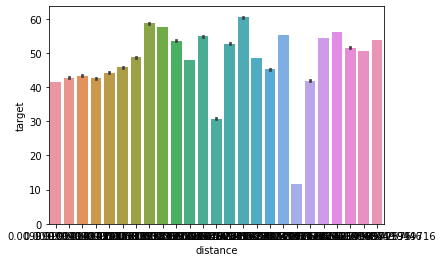

In [ ]:
sns.barplot(x='distance', y='target', data=train)
plt.show()

In [ ]:
train[['distance', 'target']].corr()

,distance,target
distance,1.000000,0.136837
target,0.136837,1.000000


우선 거리만 추가 추후 성능으로 결정

In [ ]:
train['end_turn_restricted'].value_counts()

없음    4239599
있음     461618
Name: end_turn_restricted, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51080 missing from current font.
  font.set_text

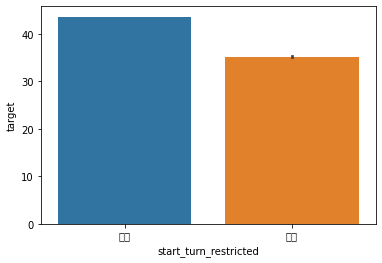

In [ ]:
sns.barplot(x='start_turn_restricted', y='target', data=train)
plt.show()

유의미함

In [ ]:
train['road_name'].value_counts()

일반국도12호선    1046092
-            569463
일반국도16호선     554510
일반국도95호선     248181
일반국도11호선     215701
             ...   
애원로            7718
아봉로            7342
남조로            6813
호서중앙로          2819
호근로             587
Name: road_name, Length: 61, dtype: int64

In [ ]:
train['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [ ]:
train['road_name_h'] = train['road_name'].str[:2]
def road_h(x):
    if x == '지방' or x == '일반':
        return x
    else:
        return ''
train['road_name_h'] = train['road_name_h'].apply(road_h)

In [ ]:
train['road_name_t'] = train['road_name'].str[-1]
def road_t(x):
    if x == '로' or x == '교':
        return x
    else:
        return ''
train['road_name_t'] = train['road_name_t'].apply(road_t)

In [ ]:
train['road_name_c'] = train['road_name_h'] + train['road_name_t']
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,road_name_h,road_name_t,road_name_c
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,지방,,지방
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,일반,,일반
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,일반,,일반
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,,로,로
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,일반,,일반


In [ ]:
train['road_name_c'].value_counts()

일반    2147483
로     1215612
지방     698704
       579643
교       59775
Name: road_name_c, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_

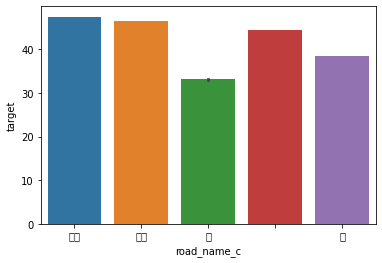

In [ ]:
sns.barplot(x='road_name_c', y='target', data=train)
plt.show()

원핫인코더?

In [ ]:
train['start_node_name'].value_counts()

고성교차로              42169
산신주유소              29386
미수2교               26635
영주교                24381
봉개교 시종점            24290
                   ...  
외산리사무소               934
와산리                  881
성미가든                 788
서귀포시 호근동 1838-4      744
CU서귀호근로점             744
Name: start_node_name, Length: 487, dtype: int64

In [ ]:
train['end_node_name'].value_counts()

고성교차로              42265
산신주유소              29202
구엄교                27510
미수2교               26621
영주교                24370
                   ...  
외산리사무소               881
대흘교차로                788
서귀포시 서호동 308-6       744
서귀포시 호근동 1838-4      744
CU서귀호근로점             587
Name: end_node_name, Length: 487, dtype: int64

In [ ]:
train['vehicle_restricted'].value_counts()

0.0    4701217
Name: vehicle_restricted, dtype: int64

0 만 있음 제거

# future enginearing

In [42]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

id - 제거

base_date - 월만 뽑아서 씀(7월만 변동이 있음)

day_of_week - 의미없음 제거

base_hour - 시간대별 변동 있음 8등분?

road_in_use - 0, 1 그대로 사용

lane_count - 1, 2, 3 원핫인코딩

road_rating - 3가지 값 라벨인코딩 원핫인코딩

multi_linked - 0, 1 그대로 사용

connect_code - 0, 103 -> 0, 1로 변경

maximum_speed_limit - 40에서 가장 높음 원핫인코딩 

vehicle_restricted - 0만 가짐 제거

weight_restricted - 최고값에서 감소, 원핫인코딩 

height_restricted - 0만 가짐 제거

road_type - 0, 1 그대로 사용

road_name - 지방, 국도, 로, 교, 기타 로 나눈다 원핫 인코딩

start_node_name - 600개정도 제거 고려

end_node_name - 600개정도 제거 고려

start_latitude, start_longitude - 시작점으로 사용

end_latitude, end_longitude - 도착점으로 사용 거리 계산

start_turn_restricted - 0, 1 로 변환 사용

end_turn_restricted - 0, 1 로 변환 사용

## 날짜 데이터(월만 뽑아서 7월(1), 나머지(0))

In [43]:
train['month'] = pd.to_datetime(train['base_date'], format='%Y%m%d').dt.month
train['month'] = train['month'].apply(lambda x : 1 if x==7 else 0)
test['month'] = pd.to_datetime(test['base_date'], format='%Y%m%d').dt.month
test['month'] = test['month'].apply(lambda x : 1 if x==7 else 0)

## 시간 데이터 8등분 후 labelencoder

In [44]:
train['base_hour'] = pd.cut(train['base_hour'],8)
test['base_hour'] = pd.cut(test['base_hour'],8)

In [45]:
lae = LabelEncoder()
train['base_hour'] = lae.fit_transform(train[['base_hour']])
test['base_hour'] = lae.transform(test[['base_hour']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## lane_count, road_rating 원핫

In [46]:
train = pd.get_dummies(train, columns=['lane_count'])
test = pd.get_dummies(test, columns=['lane_count'])
train = pd.get_dummies(train, columns=['road_rating'])
test = pd.get_dummies(test, columns=['road_rating'])

## connect_code 0, 103 라벨 인코딩

In [47]:
train['connect_code'] = lae.fit_transform(train[['connect_code']])
test['connect_code'] = lae.transform(test[['connect_code']])

## road_type 라벨 인코딩

In [48]:
train['road_type'] = lae.fit_transform(train[['road_type']])
test['road_type'] = lae.transform(test[['road_type']])

## maximum_speed_limit(원핫인코딩)

In [49]:
train = pd.get_dummies(train, columns=['maximum_speed_limit'])
test = pd.get_dummies(test, columns=['maximum_speed_limit'])

## weight_restricted(원핫인코딩)

In [50]:
train = pd.get_dummies(train, columns=['weight_restricted'])
test = pd.get_dummies(test, columns=['weight_restricted'])

## road_name (지방, 일반, 로, 교, 로 나눈뒤 원핫인코딩)

In [51]:
train['road_name_h'] = train['road_name'].str[:2]
test['road_name_h'] = test['road_name'].str[:2]
def road_h(x):
    if x == '지방' or x == '일반':
        return x
    else:
        return ''
train['road_name_h'] = train['road_name_h'].apply(road_h)
test['road_name_h'] = test['road_name_h'].apply(road_h)

train['road_name_t'] = train['road_name'].str[-1]
test['road_name_t'] = test['road_name'].str[-1]
def road_t(x):
    if x == '로' or x == '교':
        return x
    else:
        return ''
train['road_name_t'] = train['road_name_t'].apply(road_t)
test['road_name_t'] = test['road_name_t'].apply(road_t)

train['road_name_c'] = train['road_name_h'] + train['road_name_t']
test['road_name_c'] = test['road_name_h'] + test['road_name_t']

train['road_name'] = train['road_name_c']
train = train.drop(['road_name_h', 'road_name_t', 'road_name_c'], axis=1)
test['road_name'] = test['road_name_c']
test = test.drop(['road_name_h', 'road_name_t', 'road_name_c'], axis=1)

In [52]:
train = pd.get_dummies(train, columns=['road_name'])
test = pd.get_dummies(test, columns=['road_name'])

## start_latitude, start_longitude - 시작점으로 사용
end_latitude, end_longitude - 도착점으로 사용 거리 계산

In [53]:
train['start_latitude'] = train['start_latitude'].apply(lambda x : round(x, 2))
train['start_longitude'] = train['start_longitude'].apply(lambda x : round(x, 2))
train['end_latitude'] = train['end_latitude'].apply(lambda x : round(x, 2))
train['end_longitude'] = train['end_longitude'].apply(lambda x : round(x, 2))

test['start_latitude'] = test['start_latitude'].apply(lambda x : round(x, 2))
test['start_longitude'] = test['start_longitude'].apply(lambda x : round(x, 2))
test['end_latitude'] = test['end_latitude'].apply(lambda x : round(x, 2))
test['end_longitude'] = test['end_longitude'].apply(lambda x : round(x, 2))

In [54]:
train['distance'] = ((train['end_longitude'] - train['start_longitude']) ** 2 + (train['end_latitude'] - train['start_latitude']) ** 2) **0.5
test['distance'] = ((test['end_longitude'] - test['start_longitude']) ** 2 + (test['end_latitude'] - test['start_latitude']) ** 2) **0.5

In [55]:
train['distance'] = train['distance'].apply(lambda x : round(x * 100, 2))
test['distance'] = test['distance'].apply(lambda x : round(x * 100, 2))

## start_turn_restricted 0, 1로 변환
end_turn_restricted - 0, 1 로 변환 사용

In [56]:
train['start_turn_restricted'] = lae.fit_transform(train[['start_turn_restricted']])
test['start_turn_restricted'] = lae.transform(test[['start_turn_restricted']])

train['end_turn_restricted'] = lae.fit_transform(train[['end_turn_restricted']])
test['end_turn_restricted'] = lae.transform(test[['end_turn_restricted']])

## drop feture

In [57]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'multi_linked', 'connect_code', 'vehicle_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'month', 'lane_count_1', 'lane_count_2', 'lane_count_3',
       'road_rating_103', 'road_rating_106', 'road_rating_107',
       'maximum_speed_limit_30.0', 'maximum_speed_limit_40.0',
       'maximum_speed_limit_50.0', 'maximum_speed_limit_60.0',
       'maximum_speed_limit_70.0', 'maximum_speed_limit_80.0',
       'weight_restricted_0.0', 'weight_restricted_32400.0',
       'weight_restricted_43200.0', 'weight_restricted_50000.0', 'road_name_',
       'road_name_교', 'road_name_로', 'road_name_일반', 'road_name_지방',
       'distance'],
      dtype='object')

In [58]:
train  = train.drop(['id', 'base_date', 'day_of_week', 'vehicle_restricted', 'height_restricted', 'start_node_name', 'end_node_name', 
                     'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude','road_in_use'], axis =1)
test  = test.drop(['id', 'base_date', 'day_of_week', 'vehicle_restricted', 'height_restricted', 'start_node_name', 'end_node_name', 
                     'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude','road_in_use'], axis =1)

In [59]:
train.columns

Index(['base_hour', 'multi_linked', 'connect_code', 'road_type',
       'start_turn_restricted', 'end_turn_restricted', 'target', 'month',
       'lane_count_1', 'lane_count_2', 'lane_count_3', 'road_rating_103',
       'road_rating_106', 'road_rating_107', 'maximum_speed_limit_30.0',
       'maximum_speed_limit_40.0', 'maximum_speed_limit_50.0',
       'maximum_speed_limit_60.0', 'maximum_speed_limit_70.0',
       'maximum_speed_limit_80.0', 'weight_restricted_0.0',
       'weight_restricted_32400.0', 'weight_restricted_43200.0',
       'weight_restricted_50000.0', 'road_name_', 'road_name_교', 'road_name_로',
       'road_name_일반', 'road_name_지방', 'distance'],
      dtype='object')

In [60]:
train.head()

,base_hour,multi_linked,connect_code,road_type,start_turn_restricted,end_turn_restricted,target,month,lane_count_1,lane_count_2,lane_count_3,road_rating_103,road_rating_106,road_rating_107,maximum_speed_limit_30.0,maximum_speed_limit_40.0,maximum_speed_limit_50.0,maximum_speed_limit_60.0,maximum_speed_limit_70.0,maximum_speed_limit_80.0,weight_restricted_0.0,weight_restricted_32400.0,weight_restricted_43200.0,weight_restricted_50000.0,road_name_,road_name_교,road_name_로,road_name_일반,road_name_지방,distance
430379,5,0,0,1,1,0,37.0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.0
369019,3,0,0,0,0,0,36.0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.0
1132647,1,0,0,0,0,0,43.0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.0
4543127,5,0,0,0,0,0,55.0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1.0
3428956,3,0,0,1,0,0,53.0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0.0


In [61]:
train.describe()

,base_hour,multi_linked,connect_code,road_type,start_turn_restricted,end_turn_restricted,target,month,lane_count_1,lane_count_2,lane_count_3,road_rating_103,road_rating_106,road_rating_107,maximum_speed_limit_30.0,maximum_speed_limit_40.0,maximum_speed_limit_50.0,maximum_speed_limit_60.0,maximum_speed_limit_70.0,maximum_speed_limit_80.0,weight_restricted_0.0,weight_restricted_32400.0,weight_restricted_43200.0,weight_restricted_50000.0,road_name_,road_name_교,road_name_로,road_name_일반,road_name_지방,distance
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,3.640578e+00,4.762597e-04,2.582735e-03,2.050746e-01,9.816947e-02,9.819117e-02,4.278844e+01,5.843061e-02,3.315165e-01,5.003156e-01,1.681679e-01,4.593515e-01,2.040944e-01,3.365541e-01,4.887266e-02,1.444307e-03,2.347652e-01,3.542855e-01,2.116637e-01,1.489687e-01,8.578362e-01,5.090278e-02,8.728825e-02,3.972801e-03,1.232964e-01,1.271479e-02,2.585739e-01,4.567930e-01,1.486219e-01,4.932778e-01
std,2.231292e+00,2.181818e-02,5.075496e-02,4.037561e-01,2.975437e-01,2.975730e-01,1.595443e+01,2.345559e-01,4.707583e-01,5.000000e-01,3.740154e-01,4.983450e-01,4.030383e-01,4.725309e-01,2.156018e-01,3.797659e-02,4.238520e-01,4.782963e-01,4.084877e-01,3.560576e-01,3.492181e-01,2.197992e-01,2.822570e-01,6.290484e-02,3.287771e-01,1.120407e-01,4.378510e-01,4.981297e-01,3.557155e-01,7.492506e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.400000e+01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.130000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


In [62]:
mms_l = ['base_hour', 'distance']
mms = MinMaxScaler()
for i in mms_l:
    train[i] = mms.fit_transform(train[[i]])
    test[i] = mms.transform(test[[i]])

In [63]:
y_train = train.pop('target')
x_train = train.copy()

In [64]:
x_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
test.to_csv('x_test.csv', index=False)

In [65]:
xx = pd.concat([x_train, y_train], axis=1)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

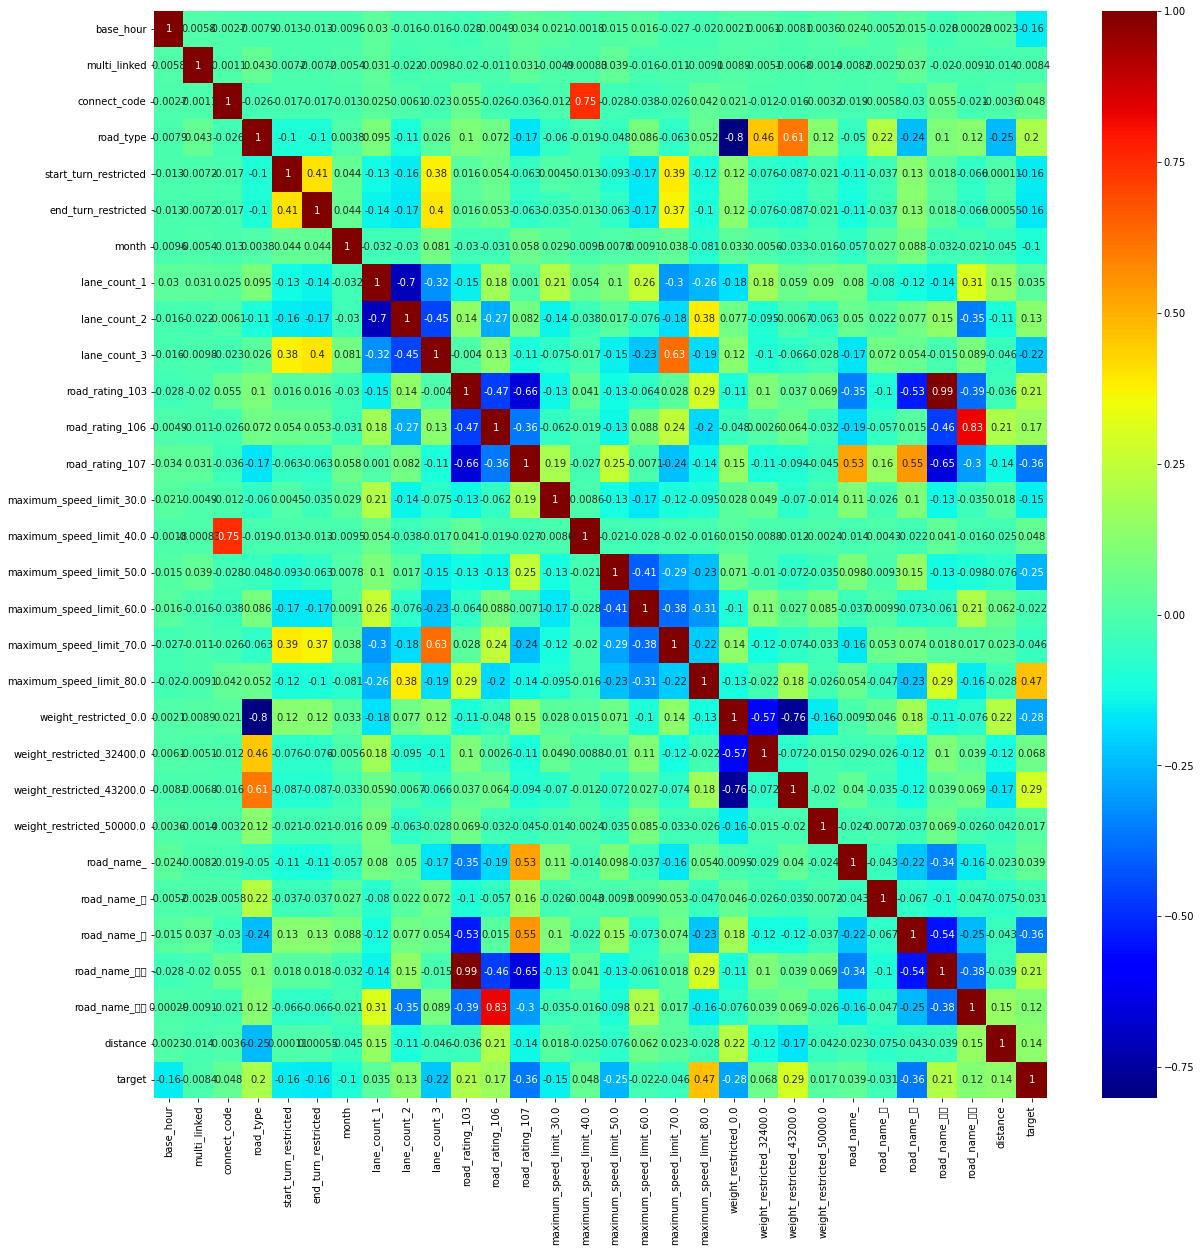

In [66]:
plt.figure(figsize=(20,20))
sns.heatmap(xx.corr(), cmap='jet', annot=True)
plt.show()

# future enginearing2

In [7]:
len(train), len(test)

(4701217, 291241)

In [9]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [40]:
train = train.sort_values('base_date')
test = test.sort_values('base_date')

In [35]:
xx =xx.reset_index()
xx

,index,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,0,TRAIN_0430379,20210901,수,16,0,3,106,지방도1132호선,0,0,70.0,0.0,0.0,0.0,3,진동1로,33.518987,126.568861,있음,동중입구,33.519726,126.571488,없음,37.0
1,1,TRAIN_0369019,20210901,수,11,0,1,103,일반국도16호선,0,0,50.0,0.0,0.0,0.0,0,모살물교,33.312509,126.703863,없음,한남교,33.312449,126.696173,없음,36.0
2,2,TRAIN_1132647,20210901,수,4,0,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,43.0
3,3,TRAIN_4543127,20210901,수,16,0,1,107,-,0,0,60.0,0.0,0.0,0.0,0,서중2교,33.331742,126.676431,없음,한남교차로,33.325096,126.665698,없음,55.0
4,4,TRAIN_3428956,20210901,수,9,0,1,103,일반국도16호선,0,0,50.0,0.0,32400.0,0.0,3,월산2교,33.260056,126.490987,없음,월산2교,33.259995,126.491306,없음,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,4701212,TRAIN_2053638,20220731,일,21,0,1,107,중문로,0,0,50.0,0.0,0.0,0.0,0,신양약방,33.251716,126.425612,없음,중문한의원,33.251884,126.423200,없음,21.0
4701213,4701213,TRAIN_2748124,20220731,일,12,0,3,107,연삼로,0,0,70.0,0.0,0.0,0.0,0,제2거로교,33.508464,126.558231,없음,거로사거리,33.507349,126.556173,있음,36.0
4701214,4701214,TRAIN_2447938,20220731,일,12,0,2,107,경찰로,0,0,60.0,0.0,0.0,0.0,0,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,24.0
4701215,4701215,TRAIN_3749761,20220731,일,1,0,2,103,일반국도16호선,0,0,60.0,0.0,0.0,0.0,0,서홍교,33.264112,126.554043,없음,서흥동사무소,33.263685,126.550978,없음,37.0


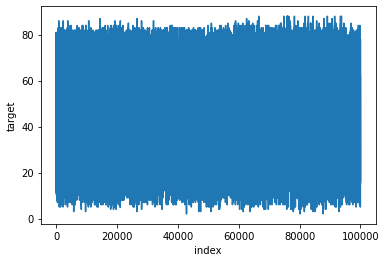

In [38]:
sns.lineplot(x='index', y='target', data=xx.iloc[:100000])
plt.show()

# data load

In [ ]:
x_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/x_train_2.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/y_train_2.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/x_test_2.csv')

In [68]:
def downcast(df, vervose = True):
    if vervose:
        mem_st = round(df.memory_usage().sum() / 1024**2, 2)
    for i in df.columns:
        columns_dtype = df[i].dtype.name
        if columns_dtype == 'object': # object 타입은 그대로 사용
            pass
        elif columns_dtype == 'bool': # bool은 int8로 변경
            df[i] = df[i].astype('int8')
        elif columns_dtype.startswith('int') or (df[i].round() == df[i]).all(): # int로 시작하거나 반올림한 값이 같으면 정수 downcast
            df[i] = pd.to_numeric(df[i], downcast='integer')
        else:
            df[i] = pd.to_numeric(df[i], downcast='float') # float downcast
    if vervose:
        mem_la = round(df.memory_usage().sum() / 1024**2, 2)
        zi = round(((mem_st - mem_la) / mem_st) * 100, 2)
        print(f'{mem_st} -> {mem_la} 압출율 : {zi}%')
    return df

x_train = downcast(x_train)
x_test = downcast(x_test)

192.79 -> 192.79 압출율 : 0.0%
25.55 -> 11.67 압출율 : 54.32%


## model select

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train, y_train, test_size=0.1)

In [83]:
x_ttrain = x_train.iloc[:4601217]
x_ttest = x_train.iloc[4601217:]
y_ttrain = y_train.iloc[:4601217]
y_ttest = y_train.iloc[4601217:]

In [71]:
lir = LinearRegression()
svr = SVR()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbr = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
# models = [lir, rfr, xgb, lgbr, cat]
# for i in models:
#     model = i.fit(x_ttrain, y_ttrain)
#     sc = round(model.score(x_ttrain, y_ttrain),2)
#     pre = model.predict(x_ttest)
#     mae = round(mean_absolute_error(pre, y_ttest),2)
#     print(f'model : {model.__class__.__name__}, sc : {sc}, mae : {mae}')


In [72]:
lir = LinearRegression()
svr = SVR()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbr = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
models = [lir, rfr, xgb, lgbr]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    sc = round(model.score(x_ttrain, y_ttrain),2)
    pre = model.predict(x_ttest)
    mae = round(mean_absolute_error(pre, y_ttest),2)
    print(f'model : {model.__class__.__name__}, sc : {sc}, mae : {mae}')


model : LinearRegression, sc : 0.5, mae : 8.6
model : RandomForestRegressor, sc : 0.69, mae : 5.54
[01:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:23:39] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
model : XGBRegressor, sc : 0.6, mae : 7.11
model : LGBMRegressor, sc : 0.67, mae : 6.02


In [ ]:
cat = CatBoostRegressor(verbose=0)
models = [cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    # sc = round(model.score(x_ttrain, y_ttrain),2)
    pre = model.predict(x_ttest)
    mae = round(mean_absolute_error(pre, y_ttest),2)
    print(f'model : {model.__class__.__name__}, sc : XX, mae : {mae}')


model : CatBoostRegressor, sc : XX, mae : 6.91


In [ ]:
cat = CatBoostRegressor(verbose=0)
models = [cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    # sc = round(model.score(x_ttrain, y_ttrain),2)
    pre = model.predict(x_ttest)
    mae = round(mean_absolute_error(pre, y_ttest),2)
    print(f'model : {model.__class__.__name__}, sc : XX, mae : {mae}')

model : CatBoostRegressor, sc : XX, mae : 6.73


In [73]:
cat = CatBoostRegressor(verbose=0)
models = [cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    # sc = round(model.score(x_ttrain, y_ttrain),2)
    pre = model.predict(x_ttest)
    mae = round(mean_absolute_error(pre, y_ttest),2)
    print(f'model : {model.__class__.__name__}, sc : XX, mae : {mae}')

model : CatBoostRegressor, sc : XX, mae : 5.61


In [78]:
y_train = y_train.to_frame()

In [79]:
x_train.to_parquet('x_train.parquet')
y_train.to_parquet('y_train.parquet')
x_test.to_parquet('x_test.parquet')

In [6]:
x_train = pd.read_parquet('x_train.parquet')
y_train = pd.read_parquet('y_train.parquet')
x_test = pd.read_parquet('x_test.parquet')

# sub

In [ ]:
test['maximum_speed_limit_40.0'] = 0

NameError: ignored

In [ ]:
cat = CatBoostRegressor(verbose=0)
model = cat.fit(x_train, y_train)
pre = model.predict(test)

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/sample_submission.csv')

In [ ]:
sub['target'] = pre
sub.to_csv('submission.csv', index=False)

# optuna

In [90]:
def objective_cat(trial : optuna.Trial, x_train, y_train):
    param = {
      'learning_rate' : trial.suggest_float('learning_rate', 0.0001, 0.3),
      'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 50, 10000),
      "max_depth":trial.suggest_int("max_depth", 2, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      "random_state":42}

    len_tr = int(len(x_train) * 0.9)

    x_ttrain = x_train.iloc[:len_tr]
    y_ttrain = y_train.iloc[:len_tr]
    x_ttest = x_train.iloc[len_tr:]
    y_ttest = y_train.iloc[len_tr:]

    cat = CatBoostRegressor(**param)
    model = cat.fit(x_ttrain, y_ttrain, eval_set=[(x_ttest, y_ttest)], early_stopping_rounds=100, verbose=0)
    pre = model.predict(x_ttest)
    mae = mean_absolute_error(y_ttest, pre)

    return mae

In [91]:
study = optuna.create_study(study_name='catboost_paeam', direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

[I 2022-10-17 02:20:45,817] A new study created in memory with name: catboost_paeam


In [ ]:
study.optimize(lambda trial : objective_cat(trial, x_train, y_train), n_trials=20)
print(f'best score : {study.best_value}, params : {study.best_trial.params}')

[I 2022-10-10 01:40:25,594] Trial 0 finished with value: 6.69756354399207 and parameters: {'learning_rate': 0.11242458164232401, 'bagging_temperature': 95.07192349792751, 'n_estimators': 7334, 'max_depth': 10, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 6.69756354399207.
[I 2022-10-10 01:54:01,386] Trial 1 finished with value: 6.741934209814421 and parameters: {'learning_rate': 0.2909759646633821, 'bagging_temperature': 83.24593965363417, 'n_estimators': 2162, 'max_depth': 4, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 0 with value: 6.69756354399207.
[I 2022-10-10 02:03:41,850] Trial 2 finished with value: 6.700311350548742 and parameters: {'learning_rate': 0.08771418009571193, 'bagging_temperature':

In [ ]:
study.optimize(lambda trial : objective_cat(trial, x_train, y_train), n_trials=20)
print(f'best score : {study.best_value}, params : {study.best_trial.params}')

[I 2022-10-17 02:34:41,563] Trial 0 finished with value: 6.281732986736204 and parameters: {'learning_rate': 0.11242458164232401, 'bagging_temperature': 95.07192349792751, 'n_estimators': 7334, 'max_depth': 10, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 6.281732986736204.
[I 2022-10-17 02:50:05,954] Trial 1 finished with value: 6.325860251816325 and parameters: {'learning_rate': 0.2909759646633821, 'bagging_temperature': 83.24593965363417, 'n_estimators': 2162, 'max_depth': 4, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 0 with value: 6.281732986736204.
[I 2022-10-17 03:02:09,784] Trial 2 finished with value: 6.281660120975645 and parameters: {'learning_rate': 0.08771418009571193, 'bagging_temperatur

In [7]:
 param = {'learning_rate': 0.08771418009571193, 'bagging_temperature': 36.64252071093623, 'n_estimators': 4588, 'max_depth': 13, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}

# sub2

In [9]:
x_test['maximum_speed_limit_40.0'] = 0

In [ ]:
cat = CatBoostRegressor(**param)
model = cat.fit(x_train, y_train)
pre = model.predict(x_test)

0:	learn: 15.1827731	total: 1.34s	remaining: 1h 42m 9s
1:	learn: 14.4865290	total: 2.33s	remaining: 1h 29m 12s
2:	learn: 13.8166123	total: 3.56s	remaining: 1h 30m 42s
3:	learn: 13.2335149	total: 4.79s	remaining: 1h 31m 31s
4:	learn: 12.8110666	total: 5.63s	remaining: 1h 26m 3s
5:	learn: 12.3679948	total: 6.72s	remaining: 1h 25m 34s
6:	learn: 11.9926869	total: 7.94s	remaining: 1h 26m 39s
7:	learn: 11.6676255	total: 9.16s	remaining: 1h 27m 27s
8:	learn: 11.4503784	total: 10s	remaining: 1h 25m
9:	learn: 11.1822057	total: 11.2s	remaining: 1h 25m 42s
10:	learn: 10.9555615	total: 12.4s	remaining: 1h 26m 5s
11:	learn: 10.7153915	total: 13.6s	remaining: 1h 26m 30s
12:	learn: 10.5068022	total: 14.8s	remaining: 1h 27m 6s
13:	learn: 10.3349266	total: 16s	remaining: 1h 27m 23s
14:	learn: 10.1862521	total: 17.2s	remaining: 1h 27m 36s
15:	learn: 10.0807230	total: 18.5s	remaining: 1h 28m 1s
16:	learn: 10.0259379	total: 19.3s	remaining: 1h 26m 19s
17:	learn: 9.9089866	total: 20.5s	remaining: 1h 26m 42

In [8]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/제주도 도로 교통량 예측/sample_submission.csv')
sub['target'] = pre
sub.to_csv('submission.csv', index=False)

Index(['base_hour', 'multi_linked', 'connect_code', 'road_type',
       'start_turn_restricted', 'end_turn_restricted', 'month', 'lane_count_1',
       'lane_count_2', 'lane_count_3', 'road_rating_103', 'road_rating_106',
       'road_rating_107', 'maximum_speed_limit_30.0',
       'maximum_speed_limit_50.0', 'maximum_speed_limit_60.0',
       'maximum_speed_limit_70.0', 'maximum_speed_limit_80.0',
       'weight_restricted_0.0', 'weight_restricted_32400.0',
       'weight_restricted_43200.0', 'weight_restricted_50000.0', 'road_name_',
       'road_name_교', 'road_name_로', 'road_name_일반', 'road_name_지방',
       'distance'],
      dtype='object')